# Wasserstein GAN图像生成案例

## WGAN简介

经典的生成对抗网络(GAN, Generative Adversarial Networks)存在着一系列问题，如训练不稳定、模式崩溃、只能依赖于人眼主观判断训练效果等等。为了解决上述问题，许多工作对GAN的结构作出改良，但大多没能取得令人满意的结果。Martin Arjovsky等人在2017年提出Wasserstein GAN（WGAN）。论文的作者从经典GAN的原理出发，分析了GAN存在的问题，通过对经典GAN算法流程的简单改动，解决了GAN训练不稳定的问题，确保了生成样本的多样性，并给出了一个具体的数值来指示训练的进程。
### WGAN基本原理

#### 经典GAN存在的问题

WGAN的作者从经典GAN的原理出发，从理论上分析了GAN目标函数存在的问题。

1. 判别器性能越好的时候，生成器的训练越困难
   经典GAN的损失函数为:
   $$
   \min_{G}\max_DV(D, G)=\mathbb{E}_{x\sim p_{data}(x)}[logD(x)]+\mathbb{E}_{z\sim p_z(z)}[log(1-D(G(z)))],
   $$
   当生成器参数固定时，鉴别器存在最优解:
   $$
   D_G^*=\frac{p_{data}(x)}{p_{data}(x)+p_g(x)}
   $$
   将（2）代入（1），可以将目标函数化简为以下形式：
   $$
   C(G)=\max_{D}V(G, D_G^*)=-log(4)+2JSD(p_{data}||p_g)
   $$
   即当鉴别器性能达到较高水平后，GAN的训练目标约等价于最小化真实数据分布于生成数据分布的JS散度。同时，WGAN的作者证明，式（3）在优化过程中，会带来生成器梯度消失的问题，导致生成器无法训练。下图是固定生成器参数，使用目标函数（1）从头开始训练鉴别器时，生成器的梯度变化。

<div align=center>
   <img src="imgs/img3.png" style="zoom:50%;" />
</div>

   因此，经典GAN能够达到较好的效果需要小心把控鉴别器相对于生成器的性能，要避免出现生成器性能超出生成器一大截的情况发生。

2. 针对梯度消失的问题，经典GAN的作者GoodFellow指出, 使用对负对数目标函数($-logD$)可以一定程度上缓解梯度消失的现象，然而，WGAN的作者从数学上证明该目标函数的优化会导致生成器的模式崩溃
   作者从理论上证明了在鉴别器达到最优的情况下，优化经典GAN的目标函数等价于：（1）最大化生成数据分布与真实数据分布的JS散度；（2）导致生成器模式崩溃。此外，作者还通过数学证明该目标函数具有较大的梯度方差，这会导致生成图片质量变差。这个结论也通过实验给出了直观的结果，如下图所示:
<div align=center>   
   <img src="imgs/img1.png" style="zoom:35%;" />
</div>

   #### Wassersastein距离的引入

   WGAN为了探索更好地度量生成分布与真实数据分布之间的距离，将目光投向了wassersastein距离。

   Martin Arjovsky等人将wassersastein距离引入到GAN中，并利用其对偶问题将wassersastein距离的求解转化为：
   $$
   W(p_r, p_g)=\frac{1}{K}sup_{||f||_L}\mathbb{E}_{x\sim p_r}[f(x)]-\mathbb{E}_{x\sim p_g}[f(x)]
   $$
   其中，$||f||_L$ 表示连续函数$f$在定义域内任何一处的变化幅度是有限的（即$\frac{|f(x_1)-f(x_2)|}{|x_1-x_2|}<K, K>0$，这个条件称为K-Lipschiz连续条件），则式(4)意为，对所有满足$||f||_L$ 不超过K的函数$f$取式（4）后面期望的上界。根据深度学习的哲学，神经网络是一个万能的函数模拟器，我们可以用一个神经网络$f_\theta$来拟合函数$f$，为了使$f_\theta$满足K-Lipschiz条件，一个简单的方法是将神经网络的参数限制在一个范围之内$[-c, c]$，这样，我们就有理由相信优化$f_\theta$下对真实数据分布与生成数据分布的度量，能够缩小两者的wassersastein距离。而当这个距离越小时，说明生成分布与真实分布越接近，也指示了GAN被训练地更好了。此时，$f_\theta$与经典GAN的鉴别器已经不同了，经典GAN的鉴别器做的是一个二分类任务，而$f_{\theta}$在拟合wassersastein距离，这是一个回归任务，故网络的最后一层不需要sigmoid函数。

   综上，WGAN相较于经典GAN有四点改动：

   1. 判别器最后一层没有sigmoid函数
   2. 生成器和判别器的loss不取对数
   3. 判别器的参数必须限制在一个范围内$[-c, c]$(只需要保证其参数是有限值即可)
   4. 不使用基于动量的优化方法（不使用Adam等，使用RMSProp或SGD作为网络的优化器）
   
### WGAN网络结构

WGAN的网络结构与经典GAN网络结构大致相同，核心依然是生成器（G）和判别器（D）的对抗训练，其中判别器与传统GAN有所区别：（1）判别器的最后一层不包含sigmoid层；（2）每次反向传播更新判别器参数后，需要手动将判别器的参数限制在一个范围内。
<div align=center>   
   <img src="imgs/img2.png" style="zoom:35%;" />
</div>

## 基于Mindspore的WGAN图像生成案例

### 数据预处理及数据集的构建 
本案例使用的训练数据为二次元头像数据集。首先将数据集下载到指定路径并解压：  

In [1]:
from pathlib import Path

if not Path("./dataset/faces").exists():
    !wget -c "https://download.mindspore.cn/dataset/Faces/faces.zip"
    !unzip ./dataset/faces.zip

!rm -r dataset/faces/.ipy

rm: cannot remove 'dataset/faces/.ipy': No such file or directory


下载后的数据集目录结构如下：
```
./datasets/faces
├── 0.jpg
├── 1.jpg
├── 2.jpg
├── 3.jpg
├── 4.jpg
    ...
├── 70169.jpg
└── 70170.jpg
```

通过```ImageFolderDataset```类将自定义的图像数据集转化为MindSpore可操作的数据集，并进行图像的预处理、批量化。我们将这些功能集成为函数```create_dataset```:

In [2]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision


def create_dataset(dataset_dir, batch_size):
    
    # 数据集解析
    dataset = ds.ImageFolderDataset(dataset_dir=dataset_dir, num_parallel_workers=4, shuffle=True, decode=True)

    # 预处理
    transform_ops = [
        vision.Resize(size=64),
        vision.CenterCrop(size=64),
        vision.HWC2CHW(),
        lambda x: ((x / 255).astype("float32")),
    ]
    dataset = dataset.map(operations=transform_ops, input_columns=["image"])

    # 批量化
    dataset = dataset.batch(batch_size)

    return dataset

通过```create_dict_iterator```函数将数据集中的数据转换成字典迭代器，并使用matplotlib模块可视化部分训练数据：

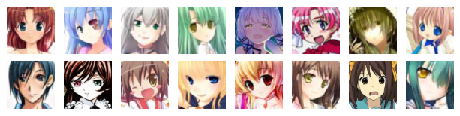

In [3]:
### 可视化部分训练数据
import matplotlib.pyplot as plt
%matplotlib inline

dataset = create_dataset("./dataset/", batch_size=16)
one_batch = next(dataset.create_dict_iterator(output_numpy=True))

def show_imgs(imgs):
    
    plt.figure(figsize=(8, 2))
    plt.subplots_adjust(hspace=0)
    for idx, img in enumerate(imgs):
        plt.subplot(2, dataset.get_batch_size() // 2, idx+1)
        plt.axis("off")
        plt.imshow(img.transpose(1, 2, 0))

show_imgs(one_batch["image"])

#### 1）构建判别器  

与经典GAN的用于分类的判别器不同，WGAN架构中的判别器是一个**回归预测网络**。判别器通过堆叠包含批归一化操作的卷积块来构建，除了最后一层没有sigmoid函数外与DCGAN中的判别器结构相似。

In [5]:
import mindspore.nn as nn

class DcganD(nn.Cell):
    """ dcgan Decriminator """
    def __init__(self, isize, nz, nc, ndf=64, n_extra_layers=0):
        super(DcganD, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.SequentialCell()
        main.append(nn.Conv2d(nc, ndf, 4, 2, 'pad', 1, has_bias=False))
        main.append(nn.LeakyReLU(0.2))

        csize, cndf = isize / 2, ndf

        # Extra layers
        for _ in range(n_extra_layers):
            main.append(nn.Conv2d(cndf, cndf, 3, 1, 'pad', 1, has_bias=False))
            main.append(nn.BatchNorm2d(cndf))
            main.append(nn.LeakyReLU(0.2))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2

            main.append(nn.Conv2d(in_feat, out_feat, 4, 2, 'pad', 1, has_bias=False))
            main.append(nn.BatchNorm2d(out_feat))
            main.append(nn.LeakyReLU(0.2))

            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.append(nn.Conv2d(cndf, 1, 4, 1, 'pad', 0, has_bias=False))
        self.main = main

    def construct(self, input1):
        """construct"""
        output = self.main(input1)
        output = output.mean(0)
        return output.view(1)


#### 2）构建生成器
与DCGAN框架的生成器一样。生成器将维度为100的先验空间$\mathbb{R}^{100}$中的隐向量z映射到图像空间，隐变量被一系列反卷积操作转化到与数据集图像具有相同维度的图像空间$\mathbb{R}^{C*H*W}$，输出数据会经过tanh函数，使其返回[-1,1]的数据范围内。

In [6]:
class DcganG(nn.Cell):
    """ dcgan generator """
    def __init__(self, isize, nz, nc, ngf=64, n_extra_layers=0):
        super(DcganG, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf // 2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.SequentialCell()
        # input is Z, going into a convolution
        main.append(nn.Conv2dTranspose(nz, cngf, 4, 1, 'pad', 0, has_bias=False))
        main.append(nn.BatchNorm2d(cngf))
        main.append(nn.ReLU())

        csize = 4
        while csize < isize // 2:
            main.append(nn.Conv2dTranspose(cngf, cngf // 2, 4, 2, 'pad', 1, has_bias=False))
            main.append(nn.BatchNorm2d(cngf // 2))
            main.append(nn.ReLU())

            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for _ in range(n_extra_layers):
            main.append(nn.Conv2d(cngf, cngf, 3, 1, 'pad', 1, has_bias=False))
            main.append(nn.BatchNorm2d(cngf))
            main.append(nn.ReLU())

        main.append(nn.Conv2dTranspose(cngf, nc, 4, 2, 'pad', 1, has_bias=False))
        main.append(nn.Tanh())
        self.main = main

    def construct(self, input1):
        """construct"""
        output = self.main(input1)
        return output

### 损失函数与权重裁切
MindSpore将损失函数、优化器等操作都封装到了```nn.Cell```中。
#### 损失函数
##### 1）判别器的损失函数  
在WGAN架构中，判别器D用于拟合真实图像分布和生成图像分布的Wasserstein距离（这里的距离我们理解成高维空间的一个向量），在训练中，我们只需要最小化两个分布Wasserstein距离的差值，就能引导生成图像分布向真实分布靠拢。因此，在计算判别器损失时，我们只需要将真实图像$I_{real}$与生成图像$I_{fake}$输入到判别器中，就能得到两者的Wasserstein距离，只要优化两个距离差值的度量$D=||I_{real}-I_{fake}||_n$即可。可以知道，当$D$的值越接近0时，两个图像分分布越接近，生成效果越好，因此WGAN判别器的损失能指示模型的训练进程。在WGAN的实现中，我们计算差值的1-范数：

In [7]:
class WithLossCell_D(nn.Cell):
    def __init__(self, netG, netD):
        super().__init__()
        self.netG = netG
        self.netD = netD
        self.log_real_pred = None
        self.log_fake_pred = None

    def construct(self, real, z):
        fake = self.netG(z)
        real_pred = self.netD(real)
        fake_pred = self.netD(fake)
        errD = real_pred - fake_pred
        self.log_real_pred = real_pred
        self.log_fake_pred = fake_pred
        return errD

##### 2）生成器的损失函数
生成器的损失函数为生成图像的Wasserstein距离。实际上，判别器可以将输入图像的Wasserstein距离映射到任意大小，只要生成图像与真实图像的Wasserstein距离的差值被优化，训练就得以进行。我们通过优化生成器生成图像的Wasserstein距离来避免其被映射成一个很大的值，

In [8]:
class WithLossCell_G(nn.Cell):
    def __init__(self, netG, netD):
        super().__init__()
        self.netG = netG
        self.netD = netD
    
    def construct(self, z):
        fake = self.netG(z)
        errG = self.netD(fake)
        return errG

### 权重裁切
由于判别器需要满足K-Lipschiz条件，我们在每次更新完判别器参数后，要手动将其参数限定在一个范围$[-c, c]$内。权重裁切操作使得判别器的训练流程与普通的“计算损失-反向传播-更新参数”不同，因此需要为判别器自定义$nn.TrainOneStepCell$来加入新的操作。我们通过定义算子```_clip_weight_by_value```来实现权重裁切，并在更新参数后通过函数```hyper_map```将判别器中每一层的参数进行权重裁切。

In [9]:
from mindspore import ops


clip_weight_by_value = ops.MultitypeFuncGraph("clip_weight_by_value")

@clip_weight_by_value.register("Number", "Tensor")
def _clip_weight_by_value(clip_value, weight):
    weight_dtype = ops.dtype(weight)
    # 将参数中超出[-clip_value, clip_value]的部分裁切
    new_weight = ops.clip_by_value(weight, 
                                   ops.cast(ops.tuple_to_array((-clip_value,)), weight_dtype),
                                   ops.cast(ops.tuple_to_array(( clip_value,)), weight_dtype))
    return ops.assign(weight, new_weight)


# 定义判别器的训练流程
class TrainOneStepCell_WithClipWeightForD(nn.TrainOneStepCell):
    def __init__(self, network, optimizer, sens=1.0,
                 clip_weight_value=0.01):
        super().__init__(network, optimizer, sens)
        self.cast = ops.Cast()
        self.hyper_map = ops.HyperMap()
        self.clip_weight_value = clip_weight_value

    def construct(self, *inputs):
        # 计算损失
        loss = self.network(*inputs)
        # 反向传播计算梯度
        grads = self.grad(self.network, self.weights)(*inputs, self.cast(ops.tuple_to_array((self.sens,)), ms.float32))
        # 更新网络参数
        self.optimizer(grads)
        # 参数裁切
        loss = ops.depend(loss, self.hyper_map(ops.partial(clip_weight_by_value, self.clip_weight_value), self.weights))
        return loss, self.network.log_real_pred, self.network.log_fake_pred

### 训练
与其他GAN模型的训练流程一样，一次完整的训练包括生成器的训练和判别器的训练，具体实现如下：

In [11]:
# 定义一个logger类来记录训练中的损失函数和生成的图片
class Logger():
    def __init__(self):
        self.log_dict = {
            "loss_G": [],
            "loss_D": [],
        }

    def record_loss(self, l_G, l_D):
        if len(self.log_dict["loss_G"]) % 1000 == 0:
            self.save_log()
        self.log_dict["loss_G"].append(l_G)
        self.log_dict["loss_D"].append(l_D)
        
    def save_log(self):
        np.save("log.npy", self.log_dict)
    
    def load_log(self):
        self.log_dict = np.load("log.npy", allow_pickle=True).item()


def gen_img(netG, fixed_z, img_save_path):
    imgs = netG(fixed_z)
    imgs = imgs.transpose(0, 2, 3, 1).asnumpy()
    row1 = imgs[ 0: 8, ...]
    row2 = imgs[ 8:16, ...]
    row3 = imgs[16:24, ...]
    li = [np.concatenate([row1[i], row2[i], row3[i]], axis=0) for i in range(len(row1))]
    img  = np.clip(np.concatenate(li, axis=1), 0, 1)
    plt.imsave(img_save_path, img)

In [12]:
# 训练模型
# 超参数设定
dim_z = 100
img_size = 64
img_channel = 3

epochs = 300
batch_size = 256
learning_rate = 5e-5
CLIP_GRAD_VALUE = 0.01
TRAIN_INTERVAL = 25  # 训练间隔，即训练判别器TRAIN_INTERVAL次后训练一次生成器

import numpy as np
ms.set_context(mode=ms.PYNATIVE_MODE)


# 实例化数据集
dataset_dir = "./dataset"
dataset = create_dataset(dataset_dir, batch_size)
dataloader = dataset.create_dict_iterator()

# 实例化生成器和判别器
netG = DcganG(img_size, dim_z, img_channel)
netD = DcganD(img_size, dim_z, img_channel)

# 将生成器和判别器与损失函数封装在一起
netG_with_criterion = WithLossCell_G(netG, netD)
netD_with_criterion = WithLossCell_D(netG, netD)

# 分别为生成器和判别器定义Adam优化器
optimizer_G = nn.RMSProp(netG.trainable_params(), learning_rate)
optimizer_D = nn.RMSProp(netD.trainable_params(), learning_rate)

# 封装生成器和判别器的一步训练流程
TrainOneStep_G = nn.TrainOneStepCell(netG_with_criterion, optimizer_G)
TrainOneStep_D = TrainOneStepCell_WithClipWeightForD(netD_with_criterion, optimizer_D, clip_weight_value=CLIP_GRAD_VALUE)

TrainOneStep_G.set_train()
TrainOneStep_D.set_train()

logger = Logger()
G_iter, D_iter = 0, 0

# 为了直观地看到生成器生成图像的效果，我们从先验空间采样一组向量来生成图像并可视化
fixed_z = ms.Tensor(np.random.randn(24, dim_z, 1, 1), dtype=ms.float32)

output_img_save_path = Path("./output")
if not output_img_save_path.exists():
    output_img_save_path.mkdir(exist_ok=True)

iter_train_D = 100
for epoch in range(1, epochs):
    acc_loss_G, acc_loss_D, acc_loss_D_real, acc_loss_D_fake, acc_iter_G, acc_iter_D= 0., 0., 0., 0., 0, 0
    for idx, data in enumerate(dataloader):
        real = data['image']
        z = ms.Tensor(np.random.randn(batch_size, dim_z, 1, 1), dtype=ms.float32)
        
        # 训练 D
        if iter_train_D > 0:
            loss, l_real, l_fake = TrainOneStep_D(real, z)
            acc_loss_D += loss.asnumpy().item()
            acc_loss_D_real += l_real.asnumpy().item()
            acc_loss_D_fake += l_fake.asnumpy().item()
        
            D_iter += 1
            acc_iter_D += 1
            iter_train_D -= 1
        else:
            loss = TrainOneStep_G(z)
            acc_loss_G += loss.asnumpy().item()

            G_iter += 1 
            acc_iter_G += 1

            if G_iter < 1 or G_iter % 500 == 0:
                iter_train_D = 100
            else:
                iter_train_D = TRAIN_INTERVAL

            if G_iter % 50 == 0:
                gen_img(netG, fixed_z,"./output/{:d}.png".format(G_iter))

    loss_G = acc_loss_G / (acc_iter_G + 1e-8)
    loss_D = acc_loss_D / acc_iter_D

    logger.record_loss(loss_G, loss_D)
    print("epoch: {:4d}/{:4d}  gen_iters:{:<6d}\tloss_G:{:4.3e}\tloss_D:{:4.3e}".format(epoch, epochs, G_iter, loss_G, loss_D))
    
    if epoch % 20 == 0:
        ms.save_checkpoint(netG, "./Generator_{:d}.ckpt".format(epoch)) 
        ms.save_checkpoint(netD, "./Discriminator_{:d}.ckpt".format(epoch))

logger.save_log()

epoch:    1/ 300  gen_iters:7     	loss_G:2.210e-01	loss_D:-3.437e-01
epoch:    2/ 300  gen_iters:18    	loss_G:7.033e-01	loss_D:-1.430e+00
epoch:    3/ 300  gen_iters:28    	loss_G:7.735e-01	loss_D:-1.546e+00
epoch:    4/ 300  gen_iters:39    	loss_G:7.791e-01	loss_D:-1.556e+00
epoch:    5/ 300  gen_iters:50    	loss_G:7.815e-01	loss_D:-1.561e+00
epoch:    6/ 300  gen_iters:60    	loss_G:7.825e-01	loss_D:-1.564e+00
epoch:    7/ 300  gen_iters:71    	loss_G:7.833e-01	loss_D:-1.565e+00


### 结果展示
运行下面代码，描绘```D```和```G```损失与训练迭代关系图：从图中可以看到，标志着生成数据分布与真实数据分布的鉴别器损失```D```的绝对值越来越接近于零，说明两个分布的量化距离越来越小；并且整个训练过程是十分稳定的。

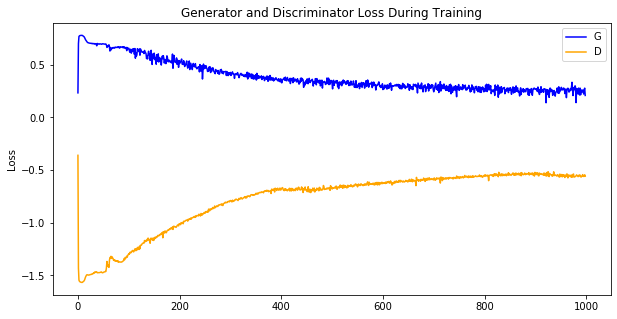

In [15]:
logger.load_log()
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(logger.log_dict["loss_G"], label="G", color='blue')
plt.plot(logger.log_dict["loss_D"], label="D", color='orange')
plt.xlabel("")
plt.ylabel("Loss")
plt.legend()
plt.show()

可视化训练过程中通过隐向量```fixed_z```生成的图像

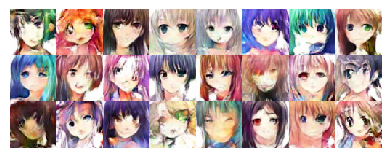

In [16]:
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.animation as animation
import numpy as np

def showGif(image_list):
    show_list = []
    fig = plt.figure(figsize=(5,2), dpi=96)
    for d in (image_list):
        plt.axis("off")
        show_list.append([plt.imshow(plt.imread(d))])
        
    ani = animation.ArtistAnimation(fig, show_list)
    ani.save('./wgan.gif', writer='pillow', fps=10, )

import re
pattern = re.compile(r"\d+")
image_list = [str(p) for p in Path("./output/").glob("*.png")]
image_indx = [int(pattern.findall(p)[0]) for p in image_list]
permu = np.argsort(image_indx, kind='heapsort')
img_list = [image_list[i] for i in permu[::3]]  # 由于存储的图像文件太多，我们每隔6张图片展示一次
showGif(img_list)

<div align=center>   
   <img src="./wgan.gif" style="zoom:100%;" />
</div>

从上面的图像可以看出，随着训练次数的增多，图像质量也越来越好。下面我们通过加载生成器网络模型参数文件Generator.ckpt来生成图像，代码如下：

[WARNING] ME(4218:281473200940928,MainProcess):2022-11-09-09:39:05.563.115 [mindspore/train/serialization.py:734] For 'load_param_into_net', remove parameter prefix name: netG., continue to load.


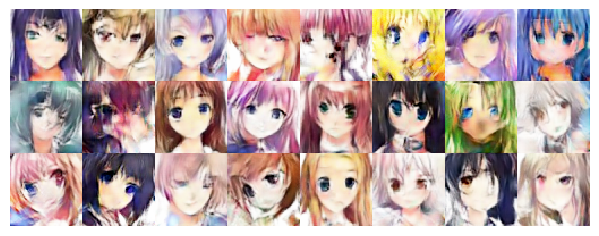

In [17]:
netG = DcganG(64, 100, 3)
param_dict = ms.load_checkpoint("./Generator_19000.ckpt", netG)
fixed_z = ms.Tensor(np.random.randn(24, 100, 1, 1), dtype=ms.float32)

imgs = netG(fixed_z)
imgs = imgs.transpose(0, 2, 3, 1).asnumpy()
row1 = imgs [0: 8, ...]
row2 = imgs[ 8:16, ...]
row3 = imgs[16:24, ...]
list = [np.concatenate([row1[i], row2[i], row3[i]], axis=0) for i in range(len(row1))]
img  = np.clip(np.concatenate(list, axis=1), 0, 1)
fig = plt.figure(figsize=(8, 3), dpi=96)
plt.axis("off")
plt.imshow(img)
plt.show()